# Memoization

Memoization is a general technique for speeding up recursive algorithms. Specifically, in this technique if there is some function ```f``` taking in some inputs ```p```, we maintain a lookup table on the side indexed by possible such inputs. If ```f(p)``` has already been calculated in the past, we return ```f(p)``` from the lookup table. Otherwise, we compute it from scratch, insert it into the lookup table, then return it. We illustrate this technique below using an example.

We will show how we can use memoization to make significant savings in running time.

# Example 1: Packing items into boxes

You have a box that can hold $W$ kilos (if you try to put more, it breaks). You are given a list $L$ of items $[ [w_0,v_0],\ldots, [w_{n-1},v_{n-1}]]$ where the $i^{th}$ item weighs $w_i$ kilos and is worth $v_i$ birr if you sell it in the market. What is the maximum amount of value you can fit in your box without the box breaking? There is only one of each item (you can't put multiple copies of the same item in your box).

We start by solving this with a simple recursive procedure. 
One way to think about this question is as follows:

* If there was only one item that has weight $w$ and has value $v$, then our decision is simple: if $W \geq w$ then we can fit the item and get $v$ value, and otherwise we get zero value (no items).

* If there are two items with weight/value $(w_0,v_0)$ and $(w_1,v_1)$ then we might have a choice to make. It's often good in such cases to split a complicated choice to a sequence of simple choices. So let's start with the choice of whether or not to put the $0$th item in the box. If we do take it, then we'll get $v_0$ value, and be left with a box that can only fit $W-w_0$ kilos more. If we don't then we get zero value, and are left with $W$ kilos to pack.

* Therefore if $\mathtt{mostValue}(W,((w_0,v_0),\ldots,(w_{n-1},v_{n-1})))$ is the maximum amount of value that we can have given a budget of $W$ and weights/values $((w_0,v_0),\ldots, (w_n,v_n))$ then we have the following equation:

$\mathtt{mostValue}(W,((w_0,v_0),\ldots,(w_{n-1},v_{n-1}))) = \max \{ 0 + \mathtt{mostValue}(W,((w_1,v_1),\ldots,(w_{n-1},v_{n-1}))) , v_0 + \mathtt{mostValue}(W-w_0,((w_1,v_1),\ldots,(w_{n-1},v_{n-1}))) \}$.

Can you see why?

This now suggests a simple recursive algorithm for the ```mostValue``` function:

In [1]:
%run  'boaz_utils.ipynb'

In [2]:
def mostValue(W,L):
    """returns the maximum amount of value we can have with W kilos packing items listed in L, 
    where L is a tuple/list containing pairs (w,v) weight/value for every item."""
    
    if not L:
        # if L is empty then we can't have any fun
        return 0
    value_if_skip_first_item = mostValue(W,L[1:]) # the amount of value we can have if we skip first item 
    if W<L[0][0]: # if we can't afford to pack the first item then we have no choices to make
        return value_if_skip_first_item
    # otherwise we will check both options and see what's the maximum value we can get
    return max(value_if_skip_first_item, L[0][1]+mostValue(W-L[0][0],L[1:]))

Here are some examples:

* $\mathtt{mostValue}(1,[[2,10]])=0$: We can't fit the first item so we get no value (:
* $\mathtt{mostValue}(2,[[2,10]])=10$
* $\mathtt{mostValue}(2,[[2,5],[2,10]])=10$: We can afford both items but the second one gives us more value
* $\mathtt{mostValue}(4,[[1,6],[2,5],[3,6],[2,10]])=16$: The best combination is to pack the first and fourth items

In [3]:
mostValue(1,[[2,10]])

0

In [4]:
mostValue(2,[[2,10]])

10

In [5]:
mostValue(2,[[2,5],[2,10]])

10

In [6]:
mostValue(4,[[1,6],[2,5],[3,6],[2,10]])

16

So far so good, but what happens if we try a larger example?

In [7]:
n = 19
%timeit -n1 -r1 print("mostValue is .."),mostValue(n*n,[(i,i) for i in range(n)])

mostValue is ..
245 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


This starts to be a little slow. More generally, lets see how the time grows as a function of n

In [8]:
inputs = [((n*n),[(i,i) for i in range(n)]) for n in range(1,20)]

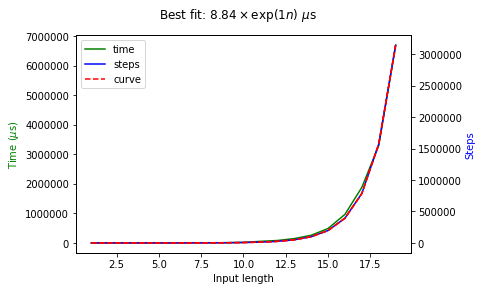

In [9]:
(curve,lengths,times,steps,outputs) = timer(mostValue,inputs,inlen = lambda i: len(i[1]) , doplot_logscale=False)

We can see that when we increase the input length by one we take about twice as much time.

When the input length was

In [11]:
lengths[-1]

19

We made 

In [12]:
print("%d calls to the function" % steps[-1])

3145725 calls to the function


But if we think about it, if our original input was a list $L$ of $n$ items, and a weight $W$, every recursive call to the function ```mostValue``` was made with a pair $(W',L')$ such that $0 \leq W' \leq W$ and $L'$ is a suffix of $L$ (i.e., the last $i$ elements of $L$ for some $i\leq n$).

Since there are $W+1$ numbers between $0$ to $W$ and there are at most $n+1$ suffixes for an $n$ length list, we see that the total number of possible inputs we could have used is $(W+1)\times (n+1)$.  But note that in our case this was

In [13]:
"{:,} possible inputs".format((inputs[-1][0]+1)*(len(inputs[-1][1])+1))

'7,240 possible inputs'

So we made a huge number of _unnecessary_ calls to the function. 
If we could simply remember the result of these calls, rather than executing them again, then we could potentially save a lot of time. 
This is what we do next. 
For starters, we use a list ```mem``` that will record for every $W'$ and $i$, the result of the function on the input which is $W'$ and the last $i$ elements of $L$. 

In [14]:
def mostValueMemo(W, L, mem):
    """returns the maximum amount of value we can pack fitting in W kilos using only items listed in L, 
    where L is a tuple/list containing pairs (w,v) of weight/value for every item."""
    
    # base case
    if len(L)==0:
        return 0
    
    # check the memory
    elif mem[W][len(L)]!=-1:
        return mem[W][len(L)]
    
    # recursive case
    A = mostValueMemo(W,L[1:],mem) # the amount of fun we can have if we skip first party 
    if W<L[0][0]: # if we can't afford to attend the first party then we have no choices to make
        mem[W][len(L)] = A
        return A
    # otherwise we will check both options and see what's the maximum fun we can have
    mem[W][len(L)] =  max(A, L[0][1]+mostValueMemo(W-L[0][0],L[1:],mem))
    return mem[W][len(L)]

def mostValueFast(W,L):
    mem = []
    for i in range(W+1):
        mem += [[-1]*(len(L)+1)]
    return mostValueMemo(W, L, mem)

Lets see that we get the same answers:

In [15]:
mostValueFast(1,[[2,10]])

0

In [16]:
mostValueFast(2,[[2,10]])

10

In [17]:
mostValueFast(2,[[2,5],[2,10]])

10

In [56]:
mostValueFast(4,[[1,6],[2,5],[3,6],[2,10]])

16

Now let's see if we indeed get a speed saving:

In [29]:
inputs = [((n*n),[(i,i) for i in range(n)]) for n in range(1,50)]

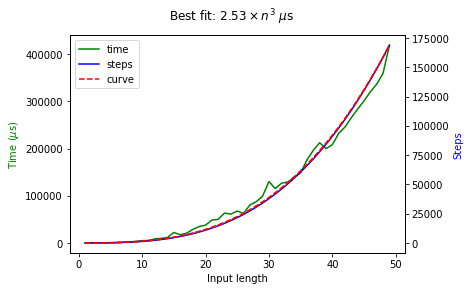

In [30]:
(_1,_2,_3,_4,outputs_mem,) = timer(mostValueFast,inputs,inlen = lambda i: len(i[1]) ,doplot_logscale = False);

In [31]:
outputs == outputs_mem[:len(outputs)] # sanity check

True

In particular for $n=40$ this took us about $35$ milliseconds instead of $40,000$ years, not bad... Note that the curve fitter estimated best fit as running time proportional to $n^3$. This makes sense: there are at most $m\cdot \mathrm{len}(L)$ inputs. For each input, we do about $O(\mathrm{len}(L))$ work (in particular, the slicing operator ```L[1:]``` creates a brand new list of size one smaller and copies all the relevant items there). If we make inputs with the length of $L$ and $W$ both being proportional to some value $n$, then our running time is thus proportional to (number of possible inputs)$\times$(work per input), which is $n^2\times n = n^3$.

We can slightly rewrite the code so the running time is only $O(W\cdot\mathrm{len}(L))$, so $O(n^2)$ in the above setup, by doing only $O(1)$ work per input. The idea is to realize that the ```L``` lists that appear in our function calls are always a suffix of the original ```L```. Thus we can keep the input ```L``` the same and just add an extra input parameter to the recursive function which keeps track of the index ```at``` such that we are only allowed to pack items from index ```at``` onward. Here's such code below.

In [49]:
# O(W * len(L)) implementation, by avoiding slicing L
def mostValueBetterMemo(W, at, L, mem):
    """returns the maximum amount of value we can pack fitting in W kilos using only items listed in L[at:], 
    where L is a tuple/list containing pairs (w,v) of weight/value for every item."""
    
    # base case
    if at == len(L):
        return 0
    
    # check the memory
    elif mem[W][at]!=-1:
        return mem[W][at]
    
    # recursive case
    A = mostValueBetterMemo(W,at+1,L,mem) # don't use item L[at]
    if W<L[at][0]: 
        mem[W][at] = A
        return A
    # second option is to use item L[at]
    mem[W][at] =  max(A, L[at][1]+mostValueBetterMemo(W-L[at][0], at+1, L,mem)) 
    return mem[W][at]

def mostValueFaster(W,L):
    mem = []
    for i in range(W+1):
        mem += [[-1]*(len(L)+1)]
    return mostValueBetterMemo(W, 0, L, mem)

## Another example: making change.

Here in Ethiopia we have a few different kinds of coins: 1, 5, 10, 25, 50, and 100 cents. Suppose someone buys a piece of gum for 88 cents and gives the shop owner one birr. Then they have to get change: 12 cents. How many ways are there for the shop owner to give this change? There are four ways:

* 1+1+1+1+1+1+1+1+1+1+1+1
* 1+1+1+1+1+1+1+5
* 1+1+5+5
* 1+1+10

Not every country has the same coin system though. For example, in the European Union (EU) their coin types are worth 1, 2, 5, 10, 20, 50, 100, and 200 cents. This changes the number of ways to give change in some cases. For example, to make change for two cents, there's only one way in Ethiopia: 1+1. But in the EU, there are two ways: 1+2, and also just giving a single 2-cent coin.

Our task now is to make a function ```countWays``` so that ```countWays(L, n)``` is the number of ways to make change for n cents using the list of coins L. The first example above corresponds to ```countWays([1,5,10,25,50,100], 12)```, which should return 4.

In [50]:
def countWays(L, n):
    # base case: there are no coins to use
    if L==[]:
        if n == 0:
            return 1
        else:
            # if there are no coins you can use, it's impossible to make change
            return 0
    
    # recursive case
    else:
        # one option we have is not using coin L[0] at all
        result = countWays(L[1:], n)
        if n>=L[0]:
            # if n>=L[0], another option is using coin L[0] at least once
            result += countWays(L, n-L[0])
        return result

In [51]:
countWays([1,5,10,25,50,100],12)

4

Unfortunately this code can be quite slow.

In [52]:
countWays([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],10)

8436285

We can speed up the computation by using memoization.

In [53]:
# how many ways are there to make change for n cents using only the coins in L[i:]?
def countWaysMemo(L, val, mem):
    # base case: there are no coins to use
    if len(L) == 0:
        if val == 0:
            return 1
        else:
            # if there are no coins you can use, it's impossible to make change
            return 0
    elif mem[len(L)][val]!=-1:
        return mem[len(L)][val]
    else:
         # one option we have is not using coin L[0] at all
        mem[len(L)][val] = countWaysMemo(L[1:], val, mem)
        if val>=L[0]:
            # if n>=L[0], another option is using coin L[0] at least once
            mem[len(L)][val] += countWaysMemo(L, val-L[0], mem)
        return mem[len(L)][val]

def countWaysFast(L, n):
    mem = []
    for i in range(len(L)+1):
        mem += [[-1]*(n+1)]
    return countWaysMemo(L, n, mem)

In [54]:
countWaysFast([1,5,10,25,50,100],12)

4

In [55]:
countWaysFast([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],10)

92561040

### How fast is the memoized version?

Let $m$ denote the length of the original list $L$. Then as we go through the recursion, then length of $L$ is always between $0$ and $m$, and $val$ is always between $0$ and $n$. Thus the total number of possible inputs to the memoized function is about $nm$. Each call only does $O(m)$ work (creating the list ```L[1:]``` takes $m$ steps), so in total the time is $O(nm^2)$.

**Bonus**: think about how to make the runtime $O(nm)$ instead of $O(nm^2)$. A hint is to avoid having to create the list ```L[1:]```. What if instead we started with a recursive function ```countWays(i, L, n)``` which computes the number of ways to make $n$ cents using only the coins in ```L[i:]```, and then we memoized that? Just like what we did with ```mostValueBetterMemo``` by avoiding slicing.